<a href="https://colab.research.google.com/github/ohvictor/ASSD-2020-G4/blob/master/RN_TP2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install (correr solo una vez)

In [3]:
pip install pandas_summary

In [4]:
pip install isoweek

# Paquetes

In [9]:
import pandas as pd
import numpy as np
import datetime

from pandas_summary import DataFrameSummary
from isoweek import Week

In [10]:
PATH = 'dataset/rossmann/'

# 1. Data Visualization

In [12]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
train, store, store_states, state_names, googletrend, weather = [pd.read_csv(PATH + fname+'.csv', 
                                                                             low_memory=False) for fname in table_names]

In [13]:
display(train.head())
display(DataFrameSummary(train).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


# 2. Missing Data

In [14]:
table_names = ['train', 'test', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
train, test, store, store_states, state_names, googletrend, weather = dfs = [pd.read_csv(PATH + fname+'.csv', 
                                                                             low_memory=False) for fname in table_names]

In [15]:
def get_missing_columns(df):
    return list(df.columns[df.describe(include = 'all').loc['count']<len(df)])

In [16]:
for i, df in enumerate(dfs):
    print(table_names[i], get_missing_columns(df))

train []
test ['Open']
store ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
store_states []
state_names []
googletrend []
weather ['Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Gust_SpeedKm_h', 'CloudCover', 'Events']


In [17]:
# Si no es dia 7 esta abierto - Verificado que el store 622 esta usualmente cerrado el día 7
test.loc[test['Open'].isna(), 'Open'] = (test[test['Open'].isna()]['DayOfWeek'] != 7)*1.0

In [18]:
# Fechas de las mas antiguas segun datos y tambien las fechas anteriores las pongo como minimo en 1990
store.loc[store['CompetitionOpenSinceYear'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceYear'] = np.int32(1990)
store.loc[store['CompetitionOpenSinceMonth'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceMonth'] = np.int32(1)

In [19]:
# Si no tengo la distancia, supongo que no hay (Como si estuviera lejos)
print(store['CompetitionDistance'].max(), store['CompetitionDistance'].mean(), store['CompetitionDistance'].min())
store.loc[store['CompetitionDistance'].isna(), 'CompetitionDistance'] = store['CompetitionDistance'].max()

75860.0 5404.901079136691 20.0


In [20]:
# Si no tiene Promo2 entonces la semana en donde empezo es cero. Esto será tratado como categórica por eso tiene sentido
store.loc[store['Promo2SinceWeek'].isna() & (store['Promo2'] == 0), 'Promo2SinceWeek'] = np.int32(1)
store.loc[store['Promo2SinceYear'].isna() & (store['Promo2'] == 0), 'Promo2SinceYear'] = np.int32(1990)
store.loc[store['PromoInterval'].isna() & (store['Promo2'] == 0), 'PromoInterval'] = '-'

In [21]:
# Supongo que son dias tranquilos (de todas formas no se usaran para la predicción)
weather.loc[weather['Max_VisibilityKm'].isna(), 'Max_VisibilityKm'] = weather['Max_VisibilityKm'].max()
weather.loc[weather['Mean_VisibilityKm'].isna(), 'Mean_VisibilityKm'] = weather['Mean_VisibilityKm'].max()
weather.loc[weather['Min_VisibilitykM'].isna(), 'Min_VisibilitykM'] = weather['Min_VisibilitykM'].max()
weather.loc[weather['Max_Gust_SpeedKm_h'].isna(), 'Max_Gust_SpeedKm_h'] = weather['Max_Gust_SpeedKm_h'].min()
weather.loc[weather['CloudCover'].isna(), 'CloudCover'] = weather['CloudCover'].min()
weather.loc[weather['Events'].isna(), 'Events'] = 'Sunny'

In [22]:
for i, df in enumerate(dfs):
    print(table_names[i], get_missing_columns(df))

train []
test []
store []
store_states []
state_names []
googletrend []
weather []


In [23]:
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].astype(np.int32)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].astype(np.int32)
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].astype(np.int32)
store['Promo2SinceYear'] = store['Promo2SinceYear'].astype(np.int32)

In [24]:
# Creo una nueva columna con fecha de apertura en formato de fecha (dia 15 por que no tengo el dato y no es relevante)
store['CompetitionOpenSince'] = pd.to_datetime(store.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1))

In [25]:
store["Promo2Since"] = pd.to_datetime(store.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))

In [26]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

Join the Weather y State Names

In [27]:
weather = join_df(weather, state_names, "file", "StateName")

GoogleTrend

In [28]:
# Armo columan date con el primer día de la semana
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]

In [29]:
# Armo columna de State con el nomnre del estado
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

In [30]:
# Lo corrijo
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

Transformación de Fecha

In [31]:
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day
    
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [32]:
# Trends generales de alemania tienen el state en None
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Termino Joins

In [33]:
# Agrego acronimo de state al store
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [34]:
# Mergeo train y store
joined_train = join_df(train, store, "Store")
len(joined_train[joined_train.StoreType.isnull()])

0

In [35]:
# Mergeo test y store
joined_test = join_df(test, store, "Store")
len(joined_test[joined_test.StoreType.isnull()])

0

In [36]:
# Mergeo con googletrend
joined_train = join_df(joined_train, googletrend, ["State","Year", "Week"])
len(joined_train[joined_train.trend.isnull()])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined_test[joined_test.trend.isnull()])

joined_train = joined_train.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined_train[joined_train.trend_DE.isnull()])
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined_test[joined_test.trend_DE.isnull()])

joined_train = join_df(joined_train, weather, ["State","Date"])
len(joined_train[joined_train.Mean_TemperatureC.isnull()])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined_test[joined_test.Mean_TemperatureC.isnull()])

0

Competition Days

In [37]:
joined_train["CompetitionDaysOpen"] = joined_train.Date.subtract(joined_train["CompetitionOpenSince"]).dt.days
joined_train["CompetitionDaysOpen"][:10]

0    2510
1    2815
2    3150
3    2145
4     107
5     593
6     837
7     289
8    5463
9    2145
Name: CompetitionDaysOpen, dtype: int64

In [38]:
joined_test["CompetitionDaysOpen"] = joined_test.Date.subtract(joined_test["CompetitionOpenSince"]).dt.days
joined_test["CompetitionDaysOpen"][:10]

0    2558
1    3198
2     885
3     337
4    5511
5    2193
6    1402
7    9376
8    9376
9     551
Name: CompetitionDaysOpen, dtype: int64

In [39]:
# Corrige errores de la formula anterior
joined_train.loc[joined_train.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined_train.loc[joined_train.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [40]:
# Corrige errores de la formula anterior
joined_test.loc[joined_test.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined_test.loc[joined_test.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [41]:
# Lo pone en meses y limita a 2 años como máximo
joined_train["CompetitionMonthsOpen"] = joined_train["CompetitionDaysOpen"]//30
joined_train.loc[joined_train.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_train.CompetitionMonthsOpen.value_counts()

24    790886
0      92590
6       6356
7       6350
4       6278
5       6261
8       6203
9       6138
10      6118
11      5971
12      5867
3       5850
13      5724
15      5699
14      5655
19      5649
2       5621
18      5619
16      5618
22      5558
17      5549
20      5500
1       5482
21      5398
23      5269
Name: CompetitionMonthsOpen, dtype: int64

In [42]:
# Lo pone en meses y limita a 2 años como máximo
joined_test["CompetitionMonthsOpen"] = joined_test["CompetitionDaysOpen"]//30
joined_test.loc[joined_test.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_test.CompetitionMonthsOpen.value_counts()

24    36782
23      346
17      292
16      287
13      260
1       257
10      247
11      246
14      197
0       179
18      169
12      164
8       161
2       161
4       152
5       151
20      149
21      148
22      146
3       141
15      126
9       125
19       84
7        60
6        58
Name: CompetitionMonthsOpen, dtype: int64

In [43]:
joined_train["Promo2Days"] = joined_train.Date.subtract(joined_train["Promo2Since"]).dt.days
joined_train.loc[joined_train.Promo2Days<0, "Promo2Days"] = 0
joined_train.loc[joined_train.Promo2SinceYear<1990, "Promo2Days"] = 0
joined_train["Promo2Weeks"] = joined_train["Promo2Days"]//7
joined_train.loc[joined_train.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_train.loc[joined_train.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_train.Promo2Weeks.value_counts()

25    911602
0      70849
23      1659
21      1659
20      1659
19      1659
16      1659
15      1659
14      1659
24      1659
22      1659
18      1652
17      1633
13      1514
7       1267
6       1267
5       1263
8       1261
11      1260
10      1260
12      1260
9       1258
4       1236
3       1232
2       1232
1       1232
Name: Promo2Weeks, dtype: int64

In [44]:
joined_test["Promo2Days"] = joined_test.Date.subtract(joined_test["Promo2Since"]).dt.days
joined_test.loc[joined_test.Promo2Days<0, "Promo2Days"] = 0
joined_test.loc[joined_test.Promo2SinceYear<1990, "Promo2Days"] = 0
joined_test["Promo2Weeks"] = joined_test["Promo2Days"]//7
joined_test.loc[joined_test.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_test.loc[joined_test.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_test.Promo2Weeks.value_counts()

25    40704
19       35
18       35
20       32
23       28
22       28
21       28
14       28
13       23
9        21
12       21
11       21
10       21
15       19
24       16
17       15
16        7
8         6
Name: Promo2Weeks, dtype: int64

In [45]:
# Remove dup columns
joined_train = joined_train.loc[:,~joined_train.columns.duplicated()]
joined_test = joined_test.loc[:,~joined_test.columns.duplicated()]

In [46]:
%time joined_train.to_feather('joined_train_before_durations.fth')

CPU times: user 1.13 s, sys: 222 ms, total: 1.35 s
Wall time: 1.08 s


In [47]:
%time joined_test.to_feather('joined_test_before_durations.fth')

CPU times: user 72.5 ms, sys: 18.8 ms, total: 91.4 ms
Wall time: 111 ms


In [48]:
set(joined_train.columns) - set(joined_test.columns)

{'Customers', 'Sales'}

In [49]:
print(list(weather.columns))

['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees', 'StateName', 'State', 'Year', 'Month', 'Week', 'Day']


# 3. Preprocesamiento de Duraciones

In [50]:
joined_train = pd.read_feather('joined_train_before_durations.fth')
joined_test = pd.read_feather('joined_test_before_durations.fth')

In [51]:
joined_train['StateHoliday_bool'] = joined_train.StateHoliday!='0'
joined_test['StateHoliday_bool'] = joined_test.StateHoliday!='0'

In [52]:
columns = ["Date", "Store", "Promo", "StateHoliday_bool", "SchoolHoliday"]

In [53]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last

In [54]:
df_train = joined_train[columns]
df_test = joined_test[columns]

In [55]:
def add_elapsed(df, fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

In [56]:
fld = 'SchoolHoliday'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday
1016095,2013-01-01,1,0,True,1,0 days
1014980,2013-01-02,1,0,False,1,0 days
1013865,2013-01-03,1,0,False,1,0 days
1012750,2013-01-04,1,0,False,1,0 days
1011635,2013-01-05,1,0,False,1,0 days


In [57]:
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday
40232,2015-08-01,1,0,False,1,0 days
39376,2015-08-02,1,0,False,1,0 days
38520,2015-08-03,1,1,False,1,0 days
37664,2015-08-04,1,1,False,1,0 days
36808,2015-08-05,1,1,False,1,0 days


In [58]:
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-07-31,1,1,False,1,0 days,0 days
1115,2015-07-30,1,1,False,1,0 days,0 days
2230,2015-07-29,1,1,False,1,0 days,0 days
3345,2015-07-28,1,1,False,1,0 days,0 days
4460,2015-07-27,1,1,False,1,0 days,0 days


In [59]:
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-09-17,1,1,False,0,13 days,NaT
856,2015-09-16,1,1,False,0,12 days,NaT
1712,2015-09-15,1,1,False,0,11 days,NaT
2568,2015-09-14,1,1,False,0,10 days,NaT
3424,2015-09-13,1,0,False,0,9 days,NaT


In [60]:
fld = 'StateHoliday_bool'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')

In [61]:
fld = 'StateHoliday_bool'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

In [62]:
fld = 'Promo'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')

In [63]:
fld = 'Promo'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

In [64]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

In [65]:
df_train.sort_values('Date').head(5)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1115,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,746,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,171,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,694,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,396,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days


In [66]:
df_test.sort_values('Date').head(5)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-08-01,553,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,394,0,False,1,0 days,0 days,NaT,NaT,NaT,-2 days
2015-08-01,393,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,392,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,391,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days


In [67]:
columns = ['SchoolHoliday', 'StateHoliday_bool', 'Promo']

In [68]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df_train[a] = df_train[a].fillna(pd.Timedelta(0)).dt.days
        df_test[a] = df_test[a].fillna(pd.Timedelta(0)).dt.days

In [69]:
df_train.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1115,0,True,1,0,0,0,0,0,-6
2013-01-01,746,0,True,1,0,0,0,0,0,-6
2013-01-01,171,0,True,1,0,0,0,0,0,-6
2013-01-01,694,0,True,1,0,0,0,0,0,-6
2013-01-01,396,0,True,1,0,0,0,0,0,-6
2013-01-01,196,0,True,1,0,0,0,0,0,-6
2013-01-01,271,0,True,1,0,0,0,0,0,-6
2013-01-01,32,0,True,1,0,0,0,0,0,-6
2013-01-01,440,0,True,1,0,0,0,0,0,-6


In [70]:
df_test.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-08-01,553,0,False,0,0,-2,0,0,0,-2
2015-08-01,394,0,False,1,0,0,0,0,0,-2
2015-08-01,393,0,False,0,0,-2,0,0,0,-2
2015-08-01,392,0,False,0,0,-2,0,0,0,-2
2015-08-01,391,0,False,0,0,-2,0,0,0,-2
2015-08-01,389,0,False,0,0,-2,0,0,0,-2
2015-08-01,388,0,False,0,0,-2,0,0,0,-2
2015-08-01,387,0,False,0,0,-2,0,0,0,-2
2015-08-01,386,0,False,0,0,-2,0,0,0,-2


## Suavizado de columnas temporales

In [71]:
# Datos del store 1 ordenados por fecha
df_train[df_train[['Store']+columns]['Store'] == 1].sort_values('Date').head(20)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1,0,True,1,0,0,0,0,0,-6
2013-01-02,1,0,False,1,0,0,1,-86,0,-5
2013-01-03,1,0,False,1,0,0,2,-85,0,-4
2013-01-04,1,0,False,1,0,0,3,-84,0,-3
2013-01-05,1,0,False,1,0,0,4,-83,0,-2
2013-01-06,1,0,False,1,0,0,5,-82,0,-1
2013-01-07,1,1,False,1,0,0,6,-81,0,0
2013-01-08,1,1,False,1,0,0,7,-80,0,0
2013-01-09,1,1,False,1,0,0,8,-79,0,0


In [72]:
bwd_train = df_train[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_test = df_test[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_train.head(20)

Store  SchoolHoliday  StateHoliday_bool  Promo
Store Date                                                      
1     2013-01-01    1.0            1.0                1.0    0.0
      2013-01-02    2.0            2.0                1.0    0.0
      2013-01-03    3.0            3.0                1.0    0.0
      2013-01-04    4.0            4.0                1.0    0.0
      2013-01-05    5.0            5.0                1.0    0.0
      2013-01-06    6.0            6.0                1.0    0.0
      2013-01-07    7.0            7.0                1.0    1.0
      2013-01-08    7.0            7.0                0.0    2.0
      2013-01-09    7.0            7.0                0.0    3.0
      2013-01-10    7.0            7.0                0.0    4.0
      2013-01-11    7.0            7.0                0.0    5.0
      2013-01-12    7.0            6.0                0.0    5.0
      2013-01-13    7.0            5.0                0.0    5.0
      2013-01-14    7.0            4.0                0.0    4.0
      2013-01-15    7.0            3.0                0.0    3.0
      2013-01-16    7.0            2.0                0.0    2.0
      2013-01-17    7.0            1.0                0.0    1.0
      2013-01-18    7.0            0.0                0.0    0.0
      2013-01-19    7.0            0.0                0.0    0.0
      2013-01-20    7.0            0.0                0.0    0.0

In [73]:
bwd_train.drop('Store',1,inplace=True)
bwd_train.reset_index(inplace=True)
bwd_test.drop('Store',1,inplace=True)
bwd_test.reset_index(inplace=True)

In [74]:
bwd_train.head(20)

,Store,Date,SchoolHoliday,StateHoliday_bool,Promo
0,1,2013-01-01,1.0,1.0,0.0
1,1,2013-01-02,2.0,1.0,0.0
2,1,2013-01-03,3.0,1.0,0.0
3,1,2013-01-04,4.0,1.0,0.0
4,1,2013-01-05,5.0,1.0,0.0
5,1,2013-01-06,6.0,1.0,0.0
6,1,2013-01-07,7.0,1.0,1.0
7,1,2013-01-08,7.0,0.0,2.0
8,1,2013-01-09,7.0,0.0,3.0
9,1,2013-01-10,7.0,0.0,4.0


In [75]:
# Ordena al reves
fwd_train = df_train[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd_test = df_test[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [76]:
fwd_train.head(20)

Store  SchoolHoliday  StateHoliday_bool  Promo
Store Date                                                      
1     2015-07-31    1.0            1.0                0.0    1.0
      2015-07-30    2.0            2.0                0.0    2.0
      2015-07-29    3.0            3.0                0.0    3.0
      2015-07-28    4.0            4.0                0.0    4.0
      2015-07-27    5.0            5.0                0.0    5.0
      2015-07-26    6.0            5.0                0.0    5.0
      2015-07-25    7.0            5.0                0.0    5.0
      2015-07-24    7.0            4.0                0.0    4.0
      2015-07-23    7.0            3.0                0.0    3.0
      2015-07-22    7.0            2.0                0.0    2.0
      2015-07-21    7.0            1.0                0.0    1.0
      2015-07-20    7.0            0.0                0.0    0.0
      2015-07-19    7.0            0.0                0.0    0.0
      2015-07-18    7.0            0.0                0.0    0.0
      2015-07-17    7.0            0.0                0.0    1.0
      2015-07-16    7.0            0.0                0.0    2.0
      2015-07-15    7.0            0.0                0.0    3.0
      2015-07-14    7.0            0.0                0.0    4.0
      2015-07-13    7.0            0.0                0.0    5.0
      2015-07-12    7.0            0.0                0.0    5.0

In [77]:
fwd_train.drop('Store',1,inplace=True)
fwd_train.reset_index(inplace=True)
fwd_test.drop('Store',1,inplace=True)
fwd_test.reset_index(inplace=True)

In [78]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [79]:
df_train = df_train.merge(bwd_train, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_train = df_train.merge(fwd_train, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_test = df_test.merge(bwd_test, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd_test, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [80]:
df_train.drop(columns,1,inplace=True)
df_test.drop(columns,1,inplace=True)

In [81]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


In [82]:
df_train["Date"] = pd.to_datetime(df_train.Date)
df_test["Date"] = pd.to_datetime(df_test.Date)

In [83]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


In [84]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

In [85]:
joined_train = join_df(joined_train, df_train, ['Store', 'Date'])
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

In [86]:
joined_train.to_feather('all_preprocessed_train.fth')

In [87]:

joined_test.to_feather('all_preprocessed_test.fth')

# 4. Normalize and Encode

In [88]:
pip install pyarrow

In [89]:
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [90]:
df_train = pd.read_feather('all_preprocessed_train.fth')
df_test = pd.read_feather('all_preprocessed_test.fth')

In [91]:
# Verificación de que se hicieron bien las cosas en testa también
set(df_train.columns) - set(df_test.columns)

{'Customers', 'Sales'}

In [92]:
(df_train['CompetitionDistance'].isna()).sum()

0

## Categorical Variables

In [93]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 
            'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 
            'CompetitionOpenSinceYear', 'Promo2SinceYear', 
            'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 
            'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 
            'SchoolHoliday_bw']


In [94]:
DataFrameSummary(df_train[cat_vars]).summary().loc[['uniques', 'types', 'missing']].T

,uniques,types,missing
Store,1115,numeric,0
DayOfWeek,7,numeric,0
Year,3,numeric,0
Month,12,numeric,0
Day,31,numeric,0
StateHoliday,4,categorical,0
CompetitionMonthsOpen,25,numeric,0
Promo2Weeks,26,numeric,0
StoreType,4,categorical,0
Assortment,3,categorical,0


## Continuous Variables

In [95]:
contin_vars = ['CompetitionDistance', 
               'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 
               'Precipitationmm', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
               'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 
               'trend_DE', 'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 
               'Promo', 'SchoolHoliday', 'StateHoliday_bool']


In [96]:
DataFrameSummary(df_train[contin_vars]).summary().loc[['uniques', 'types', 'missing']].T


,uniques,types,missing
CompetitionDistance,654,numeric,0
Max_TemperatureC,50,numeric,0
Mean_TemperatureC,45,numeric,0
Min_TemperatureC,40,numeric,0
Precipitationmm,40,numeric,0
Max_Humidity,52,numeric,0
Mean_Humidity,71,numeric,0
Min_Humidity,93,numeric,0
Max_Wind_SpeedKm_h,42,numeric,0
Mean_Wind_SpeedKm_h,27,numeric,0


## Normalization and Encoding

In [97]:
pip install sklearn_pandas

In [98]:
from sklearn_pandas import DataFrameMapper

In [99]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]
mapper_cat = DataFrameMapper(cat_maps)
_ = mapper_cat.fit(df_train)
# Assortment es la novena posición en cat_maps
N = 10
print(list(zip(df_train['Assortment'].values[:N], mapper_cat.transform(df_train)[:,9][:N])))
print(list(zip(df_train['Events'].values[:N], mapper_cat.transform(df_train)[:,15][:N])))
print(list(zip(df_train['Year'].values[:N], mapper_cat.transform(df_train)[:,2][:N])))

[('a', 0), ('a', 0), ('a', 0), ('c', 2), ('a', 0), ('a', 0), ('c', 2), ('a', 0), ('c', 2), ('a', 0)]
[('Fog', 0), ('Fog', 0), ('Fog', 0), ('Sunny', 20), ('Sunny', 20), ('Sunny', 20), ('Rain', 10), ('Rain', 10), ('Fog', 0), ('Sunny', 20)]
[(2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2)]


In [100]:
mapper_cont = DataFrameMapper(contin_maps)
_ = mapper_cont.fit(df_train)
N = 10
print(df_train['CompetitionDistance'].values[:N])
print(mapper_cont.transform(df_train)[:, 0][:N])

[ 1270.   570. 14130.   620. 29910.   310. 24000.  7520.  2030.  3160.]
[-0.51104292 -0.59341201  1.00219483 -0.5875285   2.85902934 -0.62400624
  2.16359893  0.22439533 -0.42161363 -0.28864639]


In [101]:
# La hacemos con todas ahora
df_train[cat_vars] = mapper_cat.transform(df_train)
df_test[cat_vars] = mapper_cat.transform(df_test)

df_train[contin_vars] = mapper_cont.transform(df_train)
df_test[contin_vars] = mapper_cont.transform(df_test)

DataFrameSummary(df_train[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_bool_fw,StateHoliday_bool_bw,SchoolHoliday_fw,SchoolHoliday_bw
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12,52,22,6,6,3,3,8,8
types,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


## Final Processing

In [102]:
df_sales = df_train[df_train.Sales!=0]

df_test.reset_index(inplace=True)
df_sales.reset_index(inplace=True)

In [103]:
df_sales.to_feather('train_normalized_data.fth')
df_test.to_feather('test_normalized_data.fth')


## Baselines

In [104]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [105]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
len(df_train)/len(df), len(df_val)/len(df), len(df), len(df_val)

(0.9642465458145908, 0.035753454185409164, 844338, 30188)

In [106]:
final_train = False

In [107]:
def get_metric(sales, sales_):
    return np.sqrt((((sales - sales_)/sales)**2).sum()/len(sales))

In [108]:
max_sales = df_train['Sales'].max()
df.loc[:, 'Sales_norm'] = df['Sales'].values/max_sales

In [109]:
df_train.loc[:, 'Sales_norm'] = df_train['Sales'].values/max_sales
df_val.loc[:, 'Sales_norm'] = df_val['Sales'].values/max_sales

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [110]:
print('Train:')
print(get_metric(df_train['Sales_norm'], 
                 df_train['Sales_norm'].mean()))
print('Val:')
get_metric(df_val['Sales_norm'], 
           df_train['Sales_norm'].mean())

Train:
0.6371089378658443
Val:


0.5496723521813062

In [111]:
def get_mean_by_column(column, sales_str):
    group_means_dict = {}
    group_mean_list = []
    for col_value, group_df in df_train.groupby(column):
        group_mean =  group_df[group_df[sales_str] > 0][sales_str].mean()
        group_means_dict[col_value] = group_mean
        group_mean_list.append(group_mean)
    print('Train:', get_metric(df_train[sales_str], 
                               df_train[column].apply(group_means_dict.get)))
    print('Val:', get_metric(df_val[sales_str], 
                             df_val[column].apply(group_means_dict.get)))
    return group_means_dict, group_mean_list


In [112]:
# Media por store
_ = get_mean_by_column('Store', 'Sales_norm')

Train: 0.39609135212418334
Val: 0.3071746085338872


In [113]:
# Media por dia de la semana
_ = get_mean_by_column('DayOfWeek', 'Sales_norm')

Train: 0.600887492275444
Val: 0.506139218663547


In [114]:
# Media por numera de semana (1-52)
_ = get_mean_by_column('Week', 'Sales_norm')

Train: 0.6077405789213656
Val: 0.5171468581189805


In [115]:
_ = get_mean_by_column('Month', 'Sales_norm')

Train: 0.6326710739722307
Val: 0.5444650400703042


In [116]:
_ = get_mean_by_column('StateHoliday', 'Sales_norm')

Train: 0.637967104604832
Val: 0.5494193814701546


In [117]:
_ = get_mean_by_column('SchoolHoliday', 'Sales_norm')

Train: 0.6352131730794036
Val: 0.552288625488801


In [118]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [119]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))


In [120]:
def get_keras_LR(X_columns, hidden_units=1):
    inputs = []
    activation = 'linear'
    if hidden_units>1:
        activation = 'relu'
    for i, col in enumerate(X_columns):
        inp = Input(shape=(X_train[i].shape[1],), name=f"{col}_input")
        inputs.append(inp)
    if len(X_columns)>1:
        concat_out = Concatenate()(inputs)
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(inputs[0])
    if hidden_units>1:
        dense_out = Dense(1, name='Dense_out')(dense_out)
    model = Model(inputs, dense_out)
    model.compile(optimizers.Adam(lr=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model


def get_embedings_NN(X_columns, hidden_units = 20, activation = 'relu'):
    embed_outs = []
    inputs = []
    for i, col in enumerate(X_columns):
        inp = Input(shape=(1,), name=f"{col}_input")
        inputs.append(inp)
        if col in embed_outs_dict:
            embed_out = Embedding(len(np.unique(X_train[i])), embed_outs_dict[col], name=f"{col}_embedding", mask_zero=False)(inp)
            out = Flatten(name=f"{col}_flatten")(embed_out)
            embed_outs.append(out)
        else:
            embed_outs.append(inp)
        
    if len(X_columns)>1:
        concat_out = Concatenate()(embed_outs)
        dense_out = Dense(hidden_units, activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, activation=activation)(out)
    out = Dense(1)(dense_out)
    model = Model(inputs, out)
    model.compile(optimizers.Adam(lr=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model

In [121]:
with_embed = True

embed_outs_dict = {'Store': 2, 'DayOfWeek': 2} #,  'Week': 2, 'Month': 2}
X_columns = list(embed_outs_dict.keys())# + ['BeforeStateHoliday_bool', 'Max_TemperatureC'] # ['Precipitationmm']

if final_train:
    X_train = np.hsplit(df[X_columns].values, len(X_columns))
    y_train = df['Sales_norm']
else:
    X_train = np.hsplit(df_train[X_columns].values, len(X_columns))
    y_train = df_train['Sales_norm']
    
X_val = np.hsplit(df_val[X_columns].values, len(X_columns))
X_test = np.hsplit(df_test[X_columns].values, len(X_columns))

if not with_embed:
    for i in range(len(X_train)):
        X_train[i] = to_categorical(X_train[i])
        X_val[i] = to_categorical(X_val[i])
        X_test[i] = to_categorical(X_test[i])

y_val = df_val['Sales_norm']

In [122]:
if with_embed:
    model = get_embedings_NN(X_columns)
else:
    model = get_keras_LR(X_columns, hidden_units=20)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Store_embedding (Embedding)    (None, 1, 2)         2230        ['Store_input[0][0]']            
                                                                                                  
 DayOfWeek_embedding (Embedding  (None, 1, 2)        14          ['DayOfWeek_input[0][0]']        
 )                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [123]:
# weights = model.get_weights()
# weights[0] = np.array(np.array(stores_mean_list).reshape(-1, 1))
# model.set_weights(weights)

In [124]:
from tensorflow.keras import callbacks


In [125]:
# model.evaluate(X_val, y_val)

In [126]:
# np.sqrt(0.0951)

In [127]:
epochs = 5
model.compile(optimizers.Adam(lr=0.001), loss='mse', metrics=[rmspe, 'mse'])
cbs = [callbacks.ReduceLROnPlateau(monitor='val_rmspe', mode='min', verbose=1, patience=2), callbacks.ModelCheckpoint('best_val_rmspe.hdf5', monitor='val_rmspe', mode='min', verbose=1, save_best_only=True)]
if final_train:
    model.fit(X_train, y_train, epochs=epochs, callbacks=cbs)
else:
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=cbs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
25442/25443 [============================>.] - ETA: 0s - loss: 0.0020 - rmspe: 0.2909 - mse: 0.0020
Epoch 00001: val_rmspe improved from inf to 0.21523, saving model to best_val_rmspe.hdf5
25443/25443 [==============================] - 136s 5ms/step - loss: 0.0020 - rmspe: 0.2909 - mse: 0.0020 - val_loss: 0.0014 - val_rmspe: 0.2152 - val_mse: 0.0014 - lr: 0.0010
Epoch 2/5
25437/25443 [============================>.] - ETA: 0s - loss: 0.0018 - rmspe: 0.2740 - mse: 0.0018
Epoch 00002: val_rmspe did not improve from 0.21523
25443/25443 [==============================] - 133s 5ms/step - loss: 0.0018 - rmspe: 0.2740 - mse: 0.0018 - val_loss: 0.0014 - val_rmspe: 0.2155 - val_mse: 0.0014 - lr: 0.0010
Epoch 3/5
25435/25443 [============================>.] - ETA: 0s - loss: 0.0018 - rmspe: 0.2711 - mse: 0.0018
Epoch 00003: val_rmspe improved from 0.21523 to 0.21099, saving model to best_val_rmspe.hdf5
25443/25443 [==============================] - 134s 5ms/step - loss: 0.0018 - rmspe:

In [128]:
model.load_weights('best_val_rmspe.hdf5')

In [129]:
model.evaluate(X_train, y_train)

25443/25443 [==============================] - 74s 3ms/step - loss: 0.0018 - rmspe: 0.2339 - mse: 0.0018


[0.001765565830282867, 0.23393726348876953, 0.001765565830282867]

In [130]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 0.0014 - rmspe: 0.2110 - mse: 0.0014


[0.0013713679509237409, 0.2109859734773636, 0.0013713679509237409]

In [131]:
from matplotlib import pyplot as plt

In [132]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')


(7, 2)


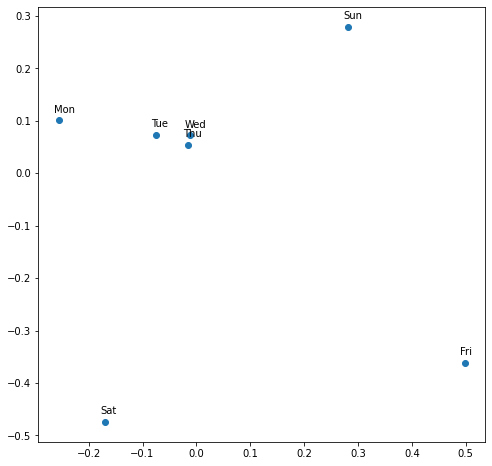

In [133]:
plot_embed('DayOfWeek_embedding', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(1115, 2)


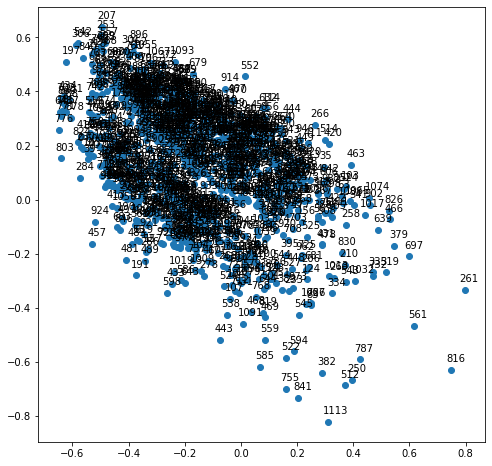

In [134]:
plot_embed('Store_embedding', list(range(1115)))

In [135]:
train_predictions = model.predict(X_train)*max_sales
get_metric(df_train['Sales'].values, train_predictions.reshape(-1))

0.311596181713891

In [136]:
test_predictions = model.predict(X_test)*max_sales
test_predictions[df_test['Open'] == 0] = 0

In [137]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = test_predictions
sample_csv.head()

sample_csv.to_csv(f'submision_baseline_{"-".join(X_columns)}.csv', index=False)

# 5. Embeddings


In [138]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [139]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [140]:
df_test = pd.read_feather('test_normalized_data.fth')

In [141]:
df_test.columns

Index(['index', 'Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCove

In [142]:
df = pd.read_feather('train_normalized_data.fth')

In [143]:
df.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitatio

In [144]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 
            'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 
            'CompetitionOpenSinceYear', 'Promo2SinceYear', 
            'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 
            'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 
            'SchoolHoliday_bw']

In [145]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [146]:
DataFrameSummary(df[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_bool_fw,StateHoliday_bool_bw,SchoolHoliday_fw,SchoolHoliday_bw
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12,52,22,6,6,3,3,8,8
types,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


In [147]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

### Asignación de dimensión de embeddings

In [148]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 4, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

## Ejemplo: Day of Week, Store y Comp Distance

In [149]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate

In [150]:
day_of_week_input = Input(shape=(1,), name="day_of_week_input")
store_input = Input(shape=(1,), name="store_input")
# Por ser continua competition_distance no necesita embeddings
competition_distance_input = Input(shape=(1,), name="competition_distance_input")

day_of_week_Embedd_out = Embedding(uniques['DayOfWeek'][0], cat_var_dict['DayOfWeek'], name="day_of_week_Embedd")(day_of_week_input)
store_Embedd_out = Embedding(uniques['Store'][0], cat_var_dict['Store'], name="store_Embedd")(store_input)

In [151]:
print(f'Entradas: {day_of_week_input.shape}, {store_input.shape}')
print(f'Salidas: {day_of_week_Embedd_out.shape}, {store_Embedd_out.shape}')

Entradas: (None, 1), (None, 1)
Salidas: (None, 1, 4), (None, 1, 50)


In [152]:
day_of_week_Embedd_flat = Flatten(name="day_of_week_flat")(day_of_week_Embedd_out)
store_Embedd_flat = Flatten(name="store_flat")(store_Embedd_out)

In [153]:
merged = Concatenate(name='All_Concatenate')([day_of_week_Embedd_flat, store_Embedd_flat, competition_distance_input])

In [154]:
x = Dense(1000, activation='relu')(merged)
x = Dense(500, activation='relu')(x)
output = Dense(1, activation='linear')(x)

In [155]:
model = Model([day_of_week_input, store_input, competition_distance_input], output)

In [156]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 day_of_week_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 day_of_week_Embedd (Embedding)  (None, 1, 4)        28          ['day_of_week_input[0][0]']      
                                                                                                  
 store_Embedd (Embedding)       (None, 1, 50)        55750       ['store_input[0][0]']            
                                                                                            

In [157]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]

In [158]:
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [159]:
df_train[['DayOfWeek', 'Store', 'CompetitionDistance']].values.shape

(814150, 3)

In [160]:
X_train = np.hsplit(df_train[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)
X_val = np.hsplit(df_val[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)

In [161]:
# Normalización
y_mean = df_train['Sales'].mean()
y_std = df_train['Sales'].std()

# Escala logaritmica
# max_log_y = np.max(np.log(df['Sales']))
# y_train = np.log(df['Sales'])/max_log_y

In [162]:
y_train = (df_train['Sales'].values - y_mean)/y_std
y_val = (df_val['Sales'].values - y_mean)/y_std

In [163]:
model.compile(optimizer=Adam(lr=0.001), metrics=['mse'], loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [164]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=1, batch_size=256)

3181/3181 [==============================] - 21s 6ms/step - loss: 0.3361 - mse: 0.3361 - val_loss: 0.2426 - val_mse: 0.2426


## Métrica

In [165]:
y_pred_norm = model.predict(X_val, verbose=1)
y_pred = y_pred_norm*y_std + y_mean
# y_pred = np.exp(model.predict(X_train)*max_log_y)

944/944 [==============================] - 2s 2ms/step


In [166]:
def root_mean_squared_error_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_pred - y_true)), axis=-1))

def rmspe_np(y_true, y_pred):
    MSEP_ = ((y_true - y_pred)/y_true)**2
    return np.sqrt(MSEP_.mean())

In [167]:
rmspe_np(df_val['Sales'].values, y_pred.reshape(-1))

0.221343399996372

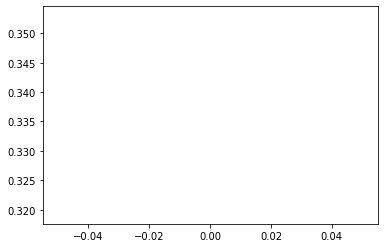

In [168]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.show()

# 6. Full Model

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [5]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

cat_vars = ['Store', 'DayOfWeek']

In [6]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [7]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [8]:
uniques.T

,uniques
Store,1115
DayOfWeek,7


## Asignación de Dimensión de Embeddings

In [9]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [10]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]



## Definición de modelo

In [11]:
add_customers = True
log_output = False
output_activation = 'linear'

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [13]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [14]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [15]:
# Descomentar para ver resultados
# cat_vars_embed_outs
# cat_var_inputs
# cont_vars_inputs
# cont_vars_outs

In [16]:
first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 1e-3
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [17]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [18]:
# Descomentar para ver
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Store_Embed (Embedding)        (None, 1, 50)        55750       ['Store_input[0][0]']            
                                                                                                  
 DayOfWeek_Embed (Embedding)    (None, 1, 2)         14          ['DayOfWeek_input[0][0]']        
                                                                                              

In [19]:
model.save_weights('initial_weights.hdf5')

In [20]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [21]:
from matplotlib import pyplot as plt
# plt.figure(figsize=(20,5))
# plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
# plt.show()
# plt.figure(figsize=(20,5))
# plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
# plt.show()

In [22]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [23]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [24]:
from tensorflow.keras import backend as K

In [25]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [26]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [27]:
get_metric(df_val, df_val['mean_by_store'])

0.30717460853388645

In [28]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [29]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
#     y_mean = df_train[y_out_columns].mean().values
#     y_std = df_train[y_out_columns].std().values
#     y_train = (df_train[y_out_columns].values - y_mean)/y_std
#     y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [30]:
lr = 0.001
model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [32]:
epochs = 20
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/20

Epoch 00001: val_Sales_mse improved from inf to 0.00172, saving model to bestmodel.hdf5
3181/3181 - 25s - loss: 0.0068 - Sales_loss: 0.0023 - Customers_loss: 8.4790e-04 - Sales_mse: 0.0023 - Sales_rmspe: 0.3536 - Customers_mse: 8.4790e-04 - Customers_rmspe: 0.3187 - val_loss: 0.0027 - val_Sales_loss: 0.0017 - val_Customers_loss: 7.5711e-04 - val_Sales_mse: 0.0017 - val_Sales_rmspe: 0.2829 - val_Customers_mse: 7.5711e-04 - val_Customers_rmspe: 0.3039 - 25s/epoch - 8ms/step
Epoch 2/20

Epoch 00002: val_Sales_mse improved from 0.00172 to 0.00143, saving model to bestmodel.hdf5
3181/3181 - 21s - loss: 0.0028 - Sales_loss: 0.0020 - Customers_loss: 6.0455e-04 - Sales_mse: 0.0020 - Sales_rmspe: 0.3319 - Customers_mse: 6.0455e-04 - Customers_rmspe: 0.2890 - val_loss: 0.0020 - val_Sales_loss: 0.0014 - val_Customers_loss: 3.9094e-04 - val_Sales_mse: 0.0014 - val_Sales_rmspe: 0.2493 - val_Customers_mse: 3.9094e-04 - val_Customers_rmspe: 0.2181 - 21s/epoch - 6ms/step
Epoch 3/20

Epoch 

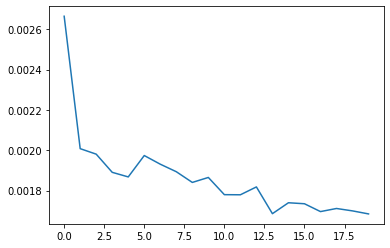

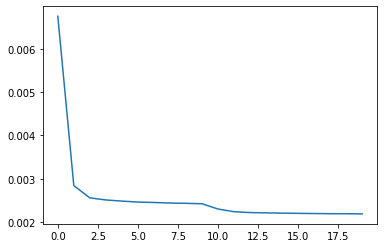

In [33]:
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

## Métrica

In [34]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 4s 5ms/step - loss: 0.0017 - Sales_loss: 0.0013 - Customers_loss: 3.0522e-04 - Sales_mse: 0.0013 - Sales_rmspe: 0.2165 - Customers_mse: 3.0522e-04 - Customers_rmspe: 0.1720


[0.0016847194638103247,
 0.0013033346040174365,
 0.00030522135784849524,
 0.0013033346040174365,
 0.2164888232946396,
 0.00030522135784849524,
 0.17198272049427032]

In [ ]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 4s 5ms/step - loss: 0.0017 - Sales_loss: 0.0013 - Customers_loss: 3.0048e-04 - Sales_mse: 0.0013 - Sales_rmspe: 0.2111 - Customers_mse: 3.0048e-04 - Customers_rmspe: 0.1720


In [ ]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [ ]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

In [ ]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

In [ ]:
y_pred_test[:10]

## Análisis de Embeddings

In [38]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


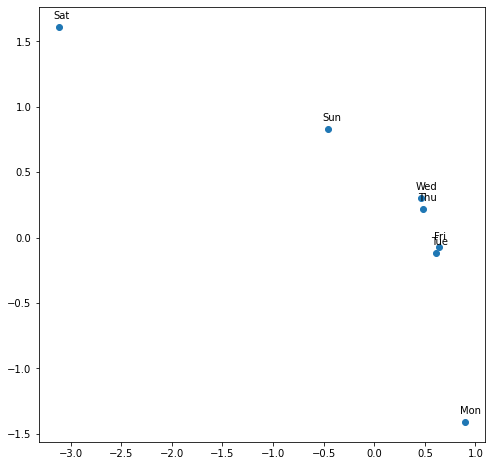

In [39]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

In [40]:
plot_embed('Month_Embed', list(range(12)))

ValueError: ignored

In [41]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [42]:
day_of_week_embedding.shape

NameError: ignored

In [ ]:
tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [43]:
cat_vars

['Store', 'DayOfWeek']

## Store Embeddings

In [44]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [45]:
submodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Store_Embed (Embedding)        (None, 1, 50)        55750       ['Store_input[0][0]']            
                                                                                                  
 DayOfWeek_Embed (Embedding)    (None, 1, 2)         14          ['DayOfWeek_input[0][0]']        
                                                                                            

In [46]:
submodel.save('embeddings_model.hdf5')